In [1]:
import pandas as pd
import numpy as np

In [2]:
import math

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/ks-projects-201801.csv')

In [4]:
df_copy = df.copy()

In [5]:
# If 'name' field is empty, drop the row
index_to_remove = []
for index, row in df_copy.iterrows():
    if row['name'] != row['name']:
        index_to_remove.append(index)
print("Removed %d rows with no 'name' field" %len(index_to_remove))
df_copy = df_copy.drop(index_to_remove)

Removed 4 rows with no 'name' field


In [ ]:
"""
Attributes to use: 
    - name
    - category
    - main_category
    - backers
    - duration (deadline - launched)
    - country
    - usd_goal_real

Objective:
    - regress usd_pledged_real OR percentage (usd_pledged_real / usd_goal_real * 100)
    - predict state (successful or not)
"""

In [6]:
# Preprocess category, main_category, country
def attr_encoding(df, attr_name):
    encoded = []
    unique_values = sorted(list(set(df[attr_name])))
    for elem in df[attr_name]:
        encoded.append(unique_values.index(elem))
    return encoded

category = attr_encoding(df_copy, 'category')
main_category = attr_encoding(df_copy, 'main_category')
country = attr_encoding(df_copy, 'country')

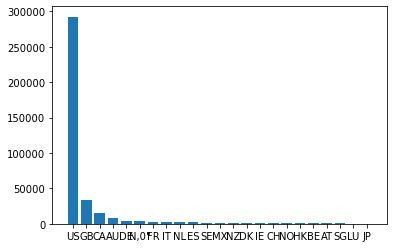

In [127]:
cs = sorted(Counter(df_copy['country']).items(), key=lambda x:x[1], reverse=True)
x = [key for key, val in cs]
label = [val for key, val in cs]
plt.bar(x, label)
plt.show()

In [7]:
"""
num_backers: skewed distribution -> range of log scale count
0: 55609
1, 2: 58065
3 ~ 7: 52998
8 ~ 20: 53692
21 ~ 47: 53213
48 ~ 116: 52449
117 ~ : 52635
"""
def encodeBackers(num_backers):
    encode_dict = {0: [0], 1: [1, 2], 2: range(3, 8), 3: range(8, 21), 4: range(21, 48), 5: range(48, 117)}
    encoded_backers = -1
    for key, val in encode_dict.items():
        if num_backers in val:
            encoded_backers = key
    if encoded_backers == -1:
        encoded_backers = 6
    return encoded_backers

backers = []
for elem in df_copy['backers']:
    backers.append(encodeBackers(elem))

In [129]:
from datetime import datetime

duration = []
duration_raw = []
for start, end in zip(df_copy['launched'], df_copy['deadline']):
    start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S').date()
    end_date = datetime.strptime(end, '%Y-%m-%d').date()
    days = 0 if (end_date - start_date).days <= 30 else 1
    duration.append(days)
    duration_raw.append((end_date - start_date).days)

In [133]:
max(df_copy['usd_goal_real'])

166361390.71

In [10]:
from collections import Counter

In [16]:
def returnGoalEncodeDict(df):
    sorted_ctr = sorted(Counter(df['usd_goal_real'].values.tolist()).items(), key=lambda x:x[0])
    counter, range_threshold = 0, []
    for key, val in sorted_ctr:
        counter += val
        if counter >= 5000 and key == int(key):
            # print(int(key), counter)
            range_threshold.append(int(key))
            counter = 0
            
    encode_dict = {key: None for key in range(len(range_threshold))}
    range_a, range_b = 0, 0
    eps = 1e-6
    for key in encode_dict.keys():
        range_b = range_threshold[key]
        encode_dict[key] = (range_a, range_b+eps)
        range_a = range_b+eps
        
    return encode_dict

def encodeGoal(goal_amount, encode_dict):
    encoded_goal = -1
    for key, val in encode_dict.items():
        if goal_amount >= val[0] and goal_amount < val[1]:
            encoded_goal = key
    if encoded_goal == -1:
        encoded_goal = len(encode_dict.keys())

    return encoded_goal

encode_dict = returnGoalEncodeDict(df_copy)

goals, pledged = [], []
for elem in df_copy['usd_goal_real']:
    goals.append(encodeGoal(elem, encode_dict))
for elem in df_copy['usd_pledged_real']:
    pledged.append(encodeGoal(elem, encode_dict))

In [17]:
states = []
for pled, goal in zip(df_copy['usd_pledged_real'], df_copy['usd_goal_real']):
    if pled >= goal:
        states.append(1)
    else:
        states.append(0)

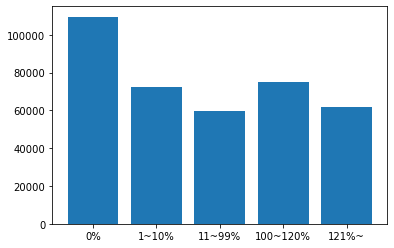

In [141]:
cs = sorted(Counter(percentage).items(), key=lambda x:x[0], reverse=False)
keydict = {0: '0%', 1: '1~10%', 2: '11~99%', 3: '100~120%', 4: '121%~'}
x = [keydict[key] for key, val in cs]
label = [val for key, val in cs]
plt.bar(x, label)
plt.show()

In [136]:
def encodePercentage(p):
    encode_dict = {0: [0], 1: range(1, 11), 2: range(11, 100), 3: range(100, 121)}
    encoded_p = -1
    for key, val in encode_dict.items():
        if p in val:
            encoded_p = key
    if encoded_p == -1:
        encoded_p = 4
    return encoded_p

percentage = []
percentage_raw = []
for pled, goal in zip(df_copy['usd_pledged_real'], df_copy['usd_goal_real']):
    p = int(pled / goal * 100)
    percentage_raw.append(p)
    percentage.append(encodePercentage(p))

In [19]:
assert len(duration) == len(category) == len(main_category) == len(country) == len(backers) == len(goals) == len(pledged) == len(states) == len(percentage)

In [ ]:
"""
<preproc>
- remove (Canceled), (Suspended)
- remove quotation in the beginning and at the end
- remove quotation elongation

- Num of words
- Num of named entities
- Use of quotation / elongation
- Num of all capital words
- Num of special characters (:, !, ?, #, etc.)

- Glove word embedding + average
- TF-IDF embedding?
"""

In [76]:
def stringProc(s):
    s = s.strip()
    s = s.replace("(Canceled)","").replace("(Suspended)","")
    s = s[1:] if s.startswith('"') else s
    s = s[:-1] if s.endswith('"') else s
    s = s.replace('""""','"').replace('"""','"').replace('""','"')
    return s

names = []
for elem in df_copy['name']:    
    names.append(stringProc(elem))

In [93]:
import spacy
nlp = spacy.load("en")

def stringEncoding(s):
    doc = nlp(s)
    
    numWords = len(doc)
    numEntities = len(doc.ents)
    
    numAllCap = 0
    for tok in doc:
        if tok.text == tok.text.upper():
            numAllCap += 1
    
    useOfQuot = 1 if '"' in doc.vocab else 0
    useOfElong, numSpecialChar = 0, 0
    
    trimmed_tokens = []
    for i, tok in enumerate(doc):
        if tok.text == '"':
            continue       ## remove quotation marks
            
        if i != numWords-1 and tok.text == doc[i+1].text:
            useOfElong = 1
            if tok.text in "`~!@#$%^&*()-_=+{}[]:;<>?/'\|,.":
                numSpecialChar += 1
            continue
        else:
            if tok.text in "`~!@#$%^&*()-_=+{}[]:;<>?/'\|,.":
                numSpecialChar += 1
            else:
                trimmed_tokens.append(tok.text)
    
    return numWords, numEntities, numAllCap, numSpecialChar, useOfQuot, useOfElong, trimmed_tokens

In [95]:
import fasttext.util

In [96]:
fasttext.util.download_model('en', if_exists='ignore')

EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
numWords, numEntities, numAllCap, numSpecialChar, useOfQuot, useOfElong = [], [], [], [], [], []
for elem in names:
    nw, ne, na, ns, uq, ue, tok = stringEncoding(elem)
    numWords.append(nw)
    numEntities.append(ne)
    numAllCap.append(na)
    numSpecialChar.append(ns)
    useOfQuot.append(uq)
    useOfElong.append(ue)

In [91]:
c = "iCare FHD: World's First Urgent Home Care Camera"
doc2 = nlp(c)
for tok in doc2:
    print(tok)

iCare
FHD
:
World
's
First
Urgent
Home
Care
Camera


In [92]:
"'s" in "`~!@#$%^&*()-_=+{}[]:;<>?/'\|,."

False

In [53]:
a = 'LEDIONIX #ONE - Linear T8 LED-Light - "One for all!!!"'
b = '1yrBeer - Discovering Craft Beer Culture in Colorado,Documentary'

In [52]:
"Linear".isalpha()

True

In [55]:
doc = nlp(a)
print(len(doc))
for tok in doc:
    print(tok)

18
LEDIONIX
#
ONE
-
Linear
T8
LED
-
Light
-
"
One
for
all
!
!
!
"


In [63]:
type(doc)

spacy.tokens.doc.Doc

In [61]:
doc = nlp(a)
tok_len = len(doc)
remove_elong = []
for i, tok in enumerate(doc):
    if i == tok_len-1:
        print("here", tok)
        remove_elong.append(tok)
    else:
        print(tok, doc[i+1])
        if tok.text == doc[i+1].text:
            continue
        else:
            remove_elong.append(tok)
print(remove_elong)

LEDIONIX #
# ONE
ONE -
- Linear
Linear T8
T8 LED
LED -
- Light
Light -
- "
" One
One for
for all
all !
! !
! !
! "
here "
[LEDIONIX, #, ONE, -, Linear, T8, LED, -, Light, -, ", One, for, all, !, "]


In [ ]:
num_words = []
for elem in names:

In [243]:
set(df['state'].values.tolist())

{'canceled', 'failed', 'live', 'successful', 'suspended', 'undefined'}

In [246]:
for row in df.values:
    print(row)
    break

[1000002330 'The Songs of Adelaide & Abullah' 'Poetry' 'Publishing' 'GBP'
 '2015-10-09' 1000.0 '2015-08-11 12:12:28' 0.0 'failed' 0 'GB' 0.0 0.0
 1533.95]


In [248]:
cnt = 0
for elem in df[df['state']=='canceled'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("canceled pledged count: %d out of %d" %(cnt, len(df[df['state']=='canceled'])))

cnt = 0
for elem in df[df['state']=='failed'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("failed pledged count: %d out of %d" %(cnt, len(df[df['state']=='failed'])))

cnt = 0
for elem in df[df['state']=='live'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("live pledged count: %d out of %d" %(cnt, len(df[df['state']=='live'])))

cnt = 0
for elem in df[df['state']=='successful'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("successful pledged count: %d out of %d" %(cnt, len(df[df['state']=='successful'])))

cnt = 0
for elem in df[df['state']=='suspended'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("suspended pledged count: %d out of %d" %(cnt, len(df[df['state']=='suspended'])))

cnt = 0
for elem in df[df['state']=='undefined'].values:
    if elem[-2] >= elem[-1]:
        cnt += 1
print("undefined pledged count: %d out of %d" %(cnt, len(df[df['state']=='undefined'])))

canceled pledged count: 698 out of 38779
failed pledged count: 6 out of 197719
live pledged count: 441 out of 2799
successful pledged count: 133951 out of 133956
suspended pledged count: 292 out of 1846
undefined pledged count: 1654 out of 3562


In [ ]:
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
def removeElongToken(doc):
    idx = []
    for i, tok in enumerate(doc):
        if i != tok_len-1 and tok.text == doc[i+1].text:
            idx.append(i)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in idx])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

In [ ]:

import re
regex = re.compile(r'(.)\1{2}')